# Data Preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import json
import librosa
import soundfile as sf
import random
import pandas as pd
from pydub import AudioSegment
from tqdm import tqdm

In [3]:
DATASET_NAME = 'dataset'
AUDIO_SOURCE = '/home/giacomoschiavo/Tovanella'

In [4]:
DATASET_PATH = f'/home/giacomoschiavo/segments/{DATASET_NAME}'
TRAIN_PATH = f'/home/giacomoschiavo/segments/{DATASET_NAME}/train'
VALID_PATH = f'/home/giacomoschiavo/segments/{DATASET_NAME}/valid'
TEST_PATH = f'/home/giacomoschiavo/segments/{DATASET_NAME}/test'

In [5]:
species_list = set(os.listdir(TEST_PATH)).intersection(set(os.listdir(TRAIN_PATH)))
if 'Engine_Engine' in species_list:
    species_list.remove('Engine_Engine')

In [6]:
def print_dataset_count_table(dataset_path):
    train_folder = f"{dataset_path}/train"
    valid_folder = f"{dataset_path}/valid"
    test_folder = f"{dataset_path}/test"

    dataset_count = {}
    for species in os.listdir(test_folder):
        if species not in species_list:
            continue
        dataset_count[species] = {
            "train": len(os.listdir(os.path.join(train_folder, species))) if os.path.exists(os.path.join(train_folder, species)) else 0,
            "valid": len(os.listdir(os.path.join(valid_folder, species))) if os.path.exists(os.path.join(valid_folder, species)) else 0,
            "test": len(os.listdir(os.path.join(test_folder, species))) if os.path.exists(os.path.join(test_folder, species)) else 0
        }

    dataset_species_count_df = pd.DataFrame.from_dict(dataset_count, orient='index')
    dataset_species_count_df.index.name = 'Species'
    return dataset_species_count_df.sort_values(by=["test"], ascending=False)


In [7]:
print_dataset_count_table(DATASET_PATH)

,train,valid,test
Species,,,
None,14727,486,4683
Fringilla coelebs_Common Chaffinch,9669,429,1370
Phylloscopus collybita_Common Chiffchaff,2189,158,674
Regulus ignicapilla_Common Firecrest,3022,104,575
Erithacus rubecula_European Robin,1701,172,556
Sylvia atricapilla_Eurasian Blackcap,3913,47,493
Turdus merula_Eurasian Blackbird,760,72,315
Periparus ater_Coal Tit,1017,94,212
Troglodytes troglodytes_Eurasian Wren,1215,138,208


In [9]:
print_dataset_count_table(DATASET_PATH)

,train,valid,test
Species,,,
None,14727,486,4683
Fringilla coelebs_Common Chaffinch,9669,429,1370
Phylloscopus collybita_Common Chiffchaff,2189,158,674
Regulus ignicapilla_Common Firecrest,3022,104,575
Erithacus rubecula_European Robin,1701,172,556
Sylvia atricapilla_Eurasian Blackcap,3913,47,493
Turdus merula_Eurasian Blackbird,760,72,315
Periparus ater_Coal Tit,1017,94,212
Troglodytes troglodytes_Eurasian Wren,1215,138,208


In [9]:
species_to_integrate = []
for species in species_list:
    species_audio = os.listdir(os.path.join(TEST_PATH, species))
    if len(species_audio) < 100:
        species_to_integrate.append(species)

In [ ]:
dates_count = utils.get_date_count(TRAIN_PATH, species_list)

# Test Integration

In [ ]:
train_integration, test_integration = utils.split_dataset(dates_count, TEST_PATH, test_ratio=0.2)

# with open(f"utils/{DATASET_NAME}/train_integration.json", 'w') as f:
#     json.dump(train_integration, f)

# with open(f"utils/{DATASET_NAME}/test_integration.json", 'w') as f:
#     json.dump(test_integration, f)

In [ ]:
utils.move_by_date(test_integration, TRAIN_PATH, TEST_PATH)

XC808139_0_63_0.wav
20200215_100000_138_0.wav
20200215_100000_279_0.wav
20200215_100000_334_5.wav
XC808139_0_31_5.wav
20200215_100000_133_5.wav
20200215_100000_256_5.wav
20190608_080000_219_0.wav
20190621_060000_189_0.wav
20200215_100000_342_0.wav
20200215_100000_346_5.wav
20200215_100000_324_0.wav
20200215_100000_276_0.wav
XC896342_0_117_0.wav
20200215_100000_204_0.wav
20200215_100000_229_5.wav
XC808139_0_70_5.wav
20190608_060000_586_5.wav
XC808139_0_66_0.wav
XC808139_0_64_5.wav
XC808139_0_51_0.wav
XC808139_0_21_0.wav
20200215_100000_333_0.wav
20190608_060000_595_5.wav
XC793860_0_16_5.wav
XC896342_0_118_5.wav
XC808139_0_40_5.wav
20190608_060000_594_0.wav
XC808139_0_36_0.wav
XC808139_0_52_5.wav
XC808139_0_48_0.wav
20200215_100000_252_0.wav
20190608_080000_237_0.wav
20200215_100000_364_5.wav
20190608_060000_585_0.wav
20200215_100000_235_5.wav
XC808139_0_58_5.wav
20200215_100000_336_0.wav
XC808139_0_57_0.wav
XC793860_0_19_5.wav
XC808139_0_25_5.wav
20200215_100000_234_0.wav
20200215_10000

# Validation creation

Prendiamo sempre 1/5 random del training set. (80/20)

ATTENZIONE: siccome e' random, bisogna salvare in un file gli esempi spostati in modo da poter annullare lo spostamento 

In [ ]:
dates_count_valid = utils.get_date_count(TRAIN_PATH)

In [13]:
for species in species_list:
    os.makedirs(os.path.join(VALID_PATH, species), exist_ok=True)

In [28]:
train_split, valid_split = split_dataset(dates_count_valid, VALID_PATH, test_ratio=0.1)

In [ ]:
utils.move_by_date(valid_split, TRAIN_PATH, VALID_PATH)

XC897680_0_75_0.wav
XC897680_0_93_0.wav
20190621_180000_351_0.wav
XC896342_0_46_5.wav
20190621_180000_336_0.wav
20190621_180000_291_0.wav
20190621_180000_541_5.wav
XC904408_0_100_5.wav
20190621_180000_265_5.wav
XC897680_0_102_0.wav
XC897680_0_106_5.wav
20190621_180000_396_0.wav
XC896342_0_121_5.wav
XC897680_0_72_0.wav
XC897680_0_133_5.wav
XC897680_0_135_0.wav
XC896342_0_108_0.wav
XC897680_0_45_0.wav
XC904408_0_66_0.wav
XC896342_0_28_5.wav
XC904408_0_87_0.wav
20190621_180000_402_0.wav
20190621_180000_397_5.wav
20190621_180000_315_0.wav
20190621_180000_274_5.wav
XC896342_0_78_0.wav
XC897680_0_145_5.wav
20190621_180000_303_0.wav
XC897680_0_6_0.wav
20190621_180000_292_5.wav
XC897680_0_54_0.wav
20190621_180000_400_5.wav
XC904408_0_40_5.wav
XC904408_0_102_0.wav
20190621_180000_330_0.wav
XC897680_0_94_5.wav
20190621_180000_399_0.wav
20190621_180000_312_0.wav
20190621_180000_522_0.wav
20190621_180000_262_5.wav
XC896342_0_51_0.wav
XC897680_0_76_5.wav
XC897680_0_52_5.wav
20190621_180000_337_5.wa

In [45]:
print_dataset_count_table(DATASET_PATH)

,train,valid,test
Species,,,
None,13374,486,4683
Fringilla coelebs_Common Chaffinch,7901,429,1370
Phylloscopus collybita_Common Chiffchaff,2014,158,674
Regulus ignicapilla_Common Firecrest,2777,104,575
Erithacus rubecula_European Robin,1554,172,556
Sylvia atricapilla_Eurasian Blackcap,3742,47,493
Turdus merula_Eurasian Blackbird,658,72,315
Periparus ater_Coal Tit,883,94,212
Troglodytes troglodytes_Eurasian Wren,1159,138,208


In [44]:
len(os.listdir(TRAIN_PATH)), len(os.listdir(TEST_PATH)), len(os.listdir(VALID_PATH))

(21, 21, 21)

Manteniamo solo le specie in cui sono presenti elementi nei tre set

In [42]:
valid_species = os.listdir(VALID_PATH)
REMOVED_PATH = f'{DATASET_PATH}/removed'
os.makedirs(REMOVED_PATH, exist_ok=True)
REMOVED_TRAIN_PATH = f'{REMOVED_PATH}/train'
os.makedirs(REMOVED_TRAIN_PATH, exist_ok=True)
for species in os.listdir(TRAIN_PATH):
    if species not in valid_species:
        os.makedirs(os.path.join(REMOVED_TRAIN_PATH, species), exist_ok=True)
        os.rename(
            os.path.join(TRAIN_PATH, species),
            os.path.join(REMOVED_TRAIN_PATH, species)
        )

In [43]:
valid_species = os.listdir(VALID_PATH)
REMOVED_TEST_PATH = f'{REMOVED_PATH}/test'
os.makedirs(REMOVED_TEST_PATH, exist_ok=True)
for species in os.listdir(TEST_PATH):
    if species not in valid_species:
        os.makedirs(os.path.join(REMOVED_TEST_PATH, species), exist_ok=True)
        os.rename(
            os.path.join(TEST_PATH, species),
            os.path.join(REMOVED_TEST_PATH, species)
        )

In [ ]:
    # for audio in os.listdir(os.path.join(TRAIN_PATH, species)):
    #     test_dates = [date for date in train_test_division[species].keys() 
    #                   if train_test_division[species][date]["is_training"] == False]
    #     audio_date = audio.split("_")[0]
    #     if audio_date in test_dates:
    #         source = os.path.join(TRAIN_PATH, species, audio)
    #         dest = os.path.join(TEST_PATH, species, audio)
    #         os.rename(source, dest)

In [ ]:
# # MOVE EVERYTHING BACK TO TRAINING
# train_folder = f"E:/Giacomo/Tovanella/{DATASET_NAME}/train"
# test_folder = f"E:/Giacomo/Tovanella/{DATASET_NAME}/test"
# valid_folder = f"E:/Giacomo/Tovanella/{DATASET_NAME}/valid"
# removed = f"E:/Giacomo/Tovanella/{DATASET_NAME}/removed"

# for species in os.listdir(test_folder):
    # for audio in os.listdir(os.path.join(test_folder, species)):
    #     os.rename(
    #         os.path.join(test_folder, species, audio),
    #         os.path.join(train_folder, species, audio),
    #     )
# for species in os.listdir(removed):
#     os.rename(
#         os.path.join(removed, species),
#         os.path.join(train_folder, species),
#     )

# Sample Removal

In [69]:
train_folder = f"{DATASET_PATH}/train"
train_removed = f"{DATASET_PATH}/train_removed"

In [ ]:

for species in os.listdir(train_removed):
    all_audio = os.listdir(os.path.join(train_removed, species))
    for audio in all_audio:
        os.rename(
            os.path.join(train_removed, species, audio),
            os.path.join(train_folder, species, audio)
        )

In [73]:

for species in os.listdir(train_folder):
    if species != 'None':
        continue
    all_audio = os.listdir(os.path.join(train_folder, species))
    if len(all_audio) <= 100:
        continue
    random.shuffle(all_audio)
    os.makedirs(os.path.join(train_removed, species), exist_ok=True)
    chosen_audio = all_audio[:1000]
    for audio in all_audio:
        if audio in chosen_audio:
            continue
        print(species, audio)
        os.rename(
            os.path.join(train_folder, species, audio),
            os.path.join(train_removed, species, audio)
        )

None 20190621_010000_75_0.wav
None XC668297_0_61_5.wav
None 20190603_160000_450_0.wav
None 20200215_090000_49_5.wav
None 20190621_110000_120_0.wav
None 20190603_190000_499_5.wav
None XC870807_0_33_0.wav
None 20190607_110000_382_5.wav
None 20190621_210000_135_0.wav
None 20190621_210000_286_5.wav
None 20200217_000000_541_5.wav
None 20190603_160000_322_5.wav
None 20190607_080000_487_5.wav
None 20200217_070000_240_0.wav
None 20200217_110000_144_0.wav
None 20190603_160000_376_5.wav
None 20190621_020000_469_5.wav
None 20190603_170000_321_0.wav
None 20190603_140000_444_0.wav
None 20190603_050000_219_0.wav
None 20190603_090000_66_0.wav
None 20200215_090000_90_0.wav
None 20200215_110000_409_5.wav
None 20190603_170000_330_0.wav
None 20200215_090000_93_0.wav
None XC980998_0_4_5.wav
None 20200217_160000_282_0.wav
None 20200215_100000_541_5.wav
None 20200217_160000_228_0.wav
None 20190603_230000_276_0.wav
None 20190603_130000_177_0.wav
None 20200217_160000_76_5.wav
None 20190603_180000_132_0.wav
No

# WABAD Integration

In [8]:
train_folder = f"{DATASET_PATH}/train"
test_folder = f"{DATASET_PATH}/test"
WABAD_FOLDER = "/home/giacomoschiavo/WABAD/segments"

dataset_species_count = {}
for species in os.listdir(test_folder):
    dataset_species_count[species] = {
        "train": len(os.listdir(os.path.join(train_folder, species))),
        "test": len(os.listdir(os.path.join(test_folder, species))),
        "wabad": len(os.listdir(os.path.join(WABAD_FOLDER, species))) if os.path.exists(os.path.join(WABAD_FOLDER, species)) else 0
    }

wabad_species = os.listdir(WABAD_FOLDER)
dataset_species_count_df = pd.DataFrame.from_dict(dataset_species_count, orient='index')
dataset_species_count_df.index.name = 'Species'
dataset_species_count_df = dataset_species_count_df.reset_index() # Make 'Species' a regular column

dataset_species_count_df["In WABAD?"] = dataset_species_count_df["Species"].apply(lambda x: x in wabad_species)
dataset_species_count_df.sort_values(by="train", ascending=False)

,Species,train,test,wabad,In WABAD?
9,None,14727,4683,18110,True
20,Fringilla coelebs_Common Chaffinch,9669,1370,0,False
15,Turdus merula_Eurasian Blackbird,7392,315,301,True
2,Periparus ater_Coal Tit,4549,212,0,True
18,Sylvia atricapilla_Eurasian Blackcap,3913,493,0,False
5,Anthus trivialis_Tree Pipit,3300,160,0,True
4,Regulus regulus_Goldcrest,3276,136,0,True
17,Regulus ignicapilla_Common Firecrest,3022,575,0,False
12,Phylloscopus collybita_Common Chiffchaff,2189,674,0,False
11,Certhia familiaris_Eurasian Treecreeper,2086,92,0,True


In [9]:
import random
WABAD_FOLDER = "/home/giacomoschiavo/WABAD/old_segments"

# MOVE WABAD TO TRAINING FOLDER
train_species = os.listdir(TRAIN_PATH)
for species in os.listdir(WABAD_FOLDER):
    if species not in train_species or species == "None":
        print(species)
        continue
    # select a maximum of 1000 segments per speciess
    all_audios = os.listdir(os.path.join(WABAD_FOLDER, species))[:4000]
    selected_audios = all_audios
        # selected_audios = random.sample(all_audios, NUM_SEGMENTS)
    for audio in selected_audios:
        os.rename(
            os.path.join(WABAD_FOLDER, species, audio),
            os.path.join(TRAIN_PATH, species, audio)
        )

## Undo WABAD

In [5]:
# move back
target_path = "/home/giacomoschiavo/WABAD/segments/"
os.makedirs(target_path, exist_ok=True)
for species in os.listdir(TRAIN_PATH):
    for audio in os.listdir(os.path.join(TRAIN_PATH, species)):
        if len(audio.split("_")[0]) <= 6:
            os.makedirs(os.path.join(target_path, species), exist_ok=True)
            os.rename(
                os.path.join(TRAIN_PATH, species, audio),
                os.path.join(target_path, species, audio)
            )

In [12]:
dataset_species_count_wabad = {}
for species in os.listdir(test_folder):
    dataset_species_count_wabad[species] = {
        "train": len(os.listdir(os.path.join(train_folder, species))),
        "test": len(os.listdir(os.path.join(test_folder, species)))
    }
dataset_species_count_df = pd.DataFrame.from_dict(dataset_species_count_wabad, orient='index')
dataset_species_count_df.index.name = 'Species'
dataset_species_count_df.sort_values(by="train", ascending=False)


NameError: name 'test_folder' is not defined

# Augmentation

In [9]:
# MOVE ALREADY CALCULATED AUGMENTATIONS
REMOVED_PATH = f'{DATASET_PATH}/augm_removed'
if os.path.exists(REMOVED_PATH):
    for species in os.listdir(REMOVED_PATH):
        for audio in os.listdir(os.path.join(REMOVED_PATH, species)):
            print(species, audio)
            os.rename(
                os.path.join(REMOVED_PATH, species, audio),
                os.path.join(TRAIN_PATH, species, audio)
            )

In [7]:
import librosa
import soundfile as sf
from audiomentations import Compose, PitchShift, TimeStretch, AddBackgroundNoise, Gain

In [8]:
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return audio, sr

def save_audio(file_path, audio, sr):
    sf.write(file_path, audio, sr)

In [30]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy import signal
import random
import torch
import torch.nn.functional as F

class SpecAugment:
    """
    Implementation of SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition
    
    Args:
        time_warping_para (int): Parameter for time warping
        frequency_masking_para (int): Maximum width of frequency masking
        time_masking_para (int): Maximum width of time masking
        frequency_mask_num (int): Number of frequency masks
        time_mask_num (int): Number of time masks
    """
    
    def __init__(self, time_warping_para=80, frequency_masking_para=27,
                 time_masking_para=100, frequency_mask_num=1, time_mask_num=1):
        self.time_warping_para = time_warping_para
        self.frequency_masking_para = frequency_masking_para
        self.time_masking_para = time_masking_para
        self.frequency_mask_num = frequency_mask_num
        self.time_mask_num = time_mask_num
        
    def time_warp(self, spec, sr):
        """
        Time warping using sparse_image_warp from tensorflow
        This is a PyTorch alternative implementation
        
        Args:
            spec: Spectrogram (batch_size, freq, time)
            sr: Sample rate
            
        Returns:
            Warped spectrogram
        """
        if self.time_warping_para == 0:
            return spec
            
        num_rows = spec.shape[0]
        spec_len = spec.shape[1]

        if spec_len <= 2 * self.time_warping_para:
            # Skippa il warping o ritorna l'originale
            return spec

        
        # Create center point for warping
        center_point = random.randint(self.time_warping_para, spec_len - self.time_warping_para)
        
        # Distance to warp 
        distance = random.randint(-self.time_warping_para, self.time_warping_para)
        
        # Linear interpolation for warping
        warped_spec = np.zeros_like(spec)
        
        # Time warping using linear interpolation
        for freq_idx in range(num_rows):
            warped_spec[freq_idx, :] = self._time_warp_row(spec[freq_idx, :], center_point, distance)
            
        return warped_spec
    
    def _time_warp_row(self, row, center_point, distance):
        """Helper function to warp a single frequency row"""
        old_length = len(row)
        new_length = old_length
        
        # Create original time points
        orig_time = np.arange(old_length)
        
        # Create warped time points
        warped_time = np.copy(orig_time).astype(np.float32)
        warped_time[center_point:] += distance
        
        # Ensure the warped time is within bounds
        warped_time = np.clip(warped_time, 0, old_length - 1)
        
        # Interpolate the new values
        return np.interp(orig_time, warped_time, row)
        
    def frequency_mask(self, spec, num_masks=1):
        """
        Apply frequency masking to the spectrogram
        
        Args:
            spec: Spectrogram (freq, time)
            num_masks: Number of frequency masks to apply
            
        Returns:
            Masked spectrogram
        """
        cloned = np.copy(spec)
        num_mel_channels = cloned.shape[0]
        
        for _ in range(num_masks):
            f = random.randint(0, self.frequency_masking_para)
            f0 = random.randint(0, num_mel_channels - f)
            cloned[f0:f0 + f, :] = 0
            
        return cloned
    
    def time_mask(self, spec, num_masks=1):
        """
        Apply time masking to the spectrogram
        
        Args:
            spec: Spectrogram (freq, time)
            num_masks: Number of time masks to apply
            
        Returns:
            Masked spectrogram
        """
        cloned = np.copy(spec)
        spec_len = cloned.shape[1]
        
        for _ in range(num_masks):
            t = min(random.randint(0, self.time_masking_para), spec_len // 5)  # Limit to 1/5 of length as recommended
            t0 = random.randint(0, spec_len - t)
            cloned[:, t0:t0 + t] = 0
            
        return cloned
        
    def __call__(self, audio, sr):
        """
        Apply SpecAugment to audio input
        
        Args:
            audio: Audio time series numpy array
            sr: Sampling rate
            
        Returns:
            Tuple of (augmented_audio, original_mel_spec, augmented_mel_spec)
        """
        # Convert to mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
        
        # Convert to log mel spectrogram
        log_mel_spec = librosa.power_to_db(mel_spec)
        
        # Store original for visualization
        original_spec = np.copy(log_mel_spec)
        
        # Apply time warping
        warped_spec = self.time_warp(log_mel_spec, sr)
        
        # Apply frequency masking
        freq_masked_spec = self.frequency_mask(warped_spec, num_masks=self.frequency_mask_num)
        
        # Apply time masking
        time_masked_spec = self.time_mask(freq_masked_spec, num_masks=self.time_mask_num)
        
        # Convert back to audio (optional)
        # This is an approximation as the phase information is lost
        # We'll use Griffin-Lim algorithm for reconstruction
        augmented_mel_spec = librosa.db_to_power(time_masked_spec)
        augmented_audio = self._mel_to_audio(augmented_mel_spec, sr)
        
        return augmented_audio, original_spec, time_masked_spec
    
    def _mel_to_audio(self, mel_spec, sr):
        """
        Convert mel spectrogram back to audio using Griffin-Lim
        """
        # Get a magnitude spectrogram from mel spectrogram
        S_inv = librosa.feature.inverse.mel_to_stft(mel_spec, sr=sr)
        
        # Griffin-Lim for phase reconstruction
        y = librosa.griffinlim(S_inv)
        
        return y
    
    def visualize(self, original_spec, augmented_spec, sr, title="SpecAugment Visualization"):
        """
        Visualize the original and augmented spectrograms
        
        Args:
            original_spec: Original mel spectrogram
            augmented_spec: Augmented mel spectrogram
            sr: Sample rate
            title: Plot title
        """
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        librosa.display.specshow(original_spec, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Original Mel Spectrogram')
        
        plt.subplot(1, 2, 2)
        librosa.display.specshow(augmented_spec, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Augmented Mel Spectrogram')
        
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()


# Example usage
def apply_spec_augment(audio, sr, params=None):
    """
    Apply SpecAugment to an audio file
    
    Args:
        audio_file_path: Path to audio file
        params: Dictionary of parameters for SpecAugment
        
    Returns:
        Tuple of (augmented_audio, original_spec, augmented_spec)
    """
    # Load audio file
    
    # Create SpecAugment instance with default or custom parameters
    if params is None:
        spec_augment = SpecAugment()
    else:
        spec_augment = SpecAugment(**params)
    
    # Apply SpecAugment
    augmented_audio, original_spec, augmented_spec = spec_augment(audio, sr)
    
    # Visualize
    # spec_augment.visualize(original_spec, augmented_spec, sr)
    
    return augmented_audio, original_spec, augmented_spec


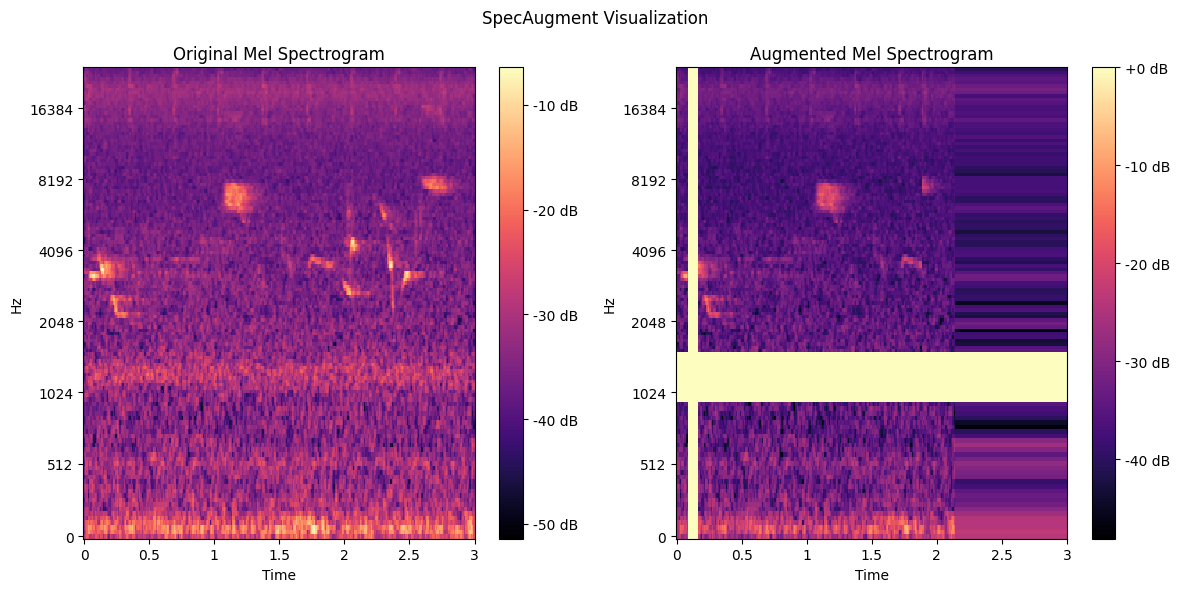

In [31]:
augmenter = SpecAugment(
    time_warping_para=15,          # Parametro per time warping
    frequency_masking_para=10,     # Larghezza massima frequency mask
    time_masking_para=20,         # Larghezza massima time mask
    frequency_mask_num=1,          # Numero di frequency mask
    time_mask_num=2                # Numero di time mask
)

# Replace with your audio file path
audio_file_path = "/home/giacomoschiavo/segments/dataset/train/Muscicapa striata_Spotted Flycatcher/20190621_040000_7_5.wav"
audio, sr = librosa.load(audio_file_path, sr=None)

augmented_audio, original_spec, augmented_spec = apply_spec_augment(audio, sr)

# Apply SpecAugment
augmenter.visualize(original_spec, augmented_spec, sr)

# Save augmented audio (optional)
# sf.write("augmented_audio.wav", augmented_audio, sr)

In [32]:

bg_noise_path = f"{DATASET_PATH}/train/None"
bg_noises = os.listdir(bg_noise_path)
augmentations = {
    # "psA": Compose([PitchShift(min_semitones=-3, max_semitones=-1, p=0.75)]),
    # "psB": Compose([PitchShift(min_semitones=1, max_semitones=3, p=0.75)]),
    # "ts": Compose([TimeStretch(min_rate=0.9, max_rate=1.1, p=0.75)]),
    "specaug": apply_spec_augment  # Aggiunto SpecAugment
}


def apply_augmentations(file_path, output_dir):
    audio, sr = load_audio(file_path)
    
    for aug_name, aug in augmentations.items():
        file_name = os.path.splitext(file_path)[0].split('/')[-1]
        if "aug" in file_name:
            continue
        save_audio_path = f"{output_dir}/{file_name}_aug_{aug_name}.wav"
        if os.path.exists(save_audio_path):
            continue
        if "specaug" in save_audio_path:
            augmented_audio, _, _ = aug(audio, sr)
        else:
            augmented_audio = aug(audio, sr)
        save_audio(save_audio_path, augmented_audio, sr)

In [33]:
# pick samples where validation samples == 0
train_folder = f'{DATASET_PATH}/train'
species_to_augment = []
threshold = 1000
for species in os.listdir(train_folder):
    if len(species.split("_")) <= 1:
        print(species, "skipped")
        continue
    if len(os.listdir(os.path.join(train_folder, species))) >= threshold:
        continue
    species_to_augment.append(species)

species_to_augment

Aeroplane skipped
Vegetation skipped
None skipped
Wind skipped


['Cuculus canorus_Common Cuckoo',
 'Parus major_Great Tit',
 'Certhia familiaris_Eurasian Treecreeper',
 'Coccothraustes coccothraustes_Hawfinch',
 'Turdus merula_Eurasian Blackbird',
 'Loxia curvirostra_Common Crossbill',
 'Lophophanes cristatus_Crested Tit']

In [34]:
for species in species_to_augment:
    files = os.listdir(os.path.join(train_folder, species))
    print("Augmenting ", species)
    for i in tqdm(range(len(files)), colour="blue"):
        audio = files[i]
        apply_augmentations(os.path.join(train_folder, species, audio), os.path.join(train_folder, species))

Augmenting  Cuculus canorus_Common Cuckoo


100%|██████████| 101/101 [00:00<00:00, 1224.91it/s]


Augmenting  Parus major_Great Tit


100%|██████████| 216/216 [00:00<00:00, 582.03it/s]


Augmenting  Certhia familiaris_Eurasian Treecreeper


100%|██████████| 756/756 [14:16<00:00,  1.13s/it]  


Augmenting  Coccothraustes coccothraustes_Hawfinch


100%|██████████| 82/82 [02:34<00:00,  1.88s/it]


Augmenting  Turdus merula_Eurasian Blackbird


100%|██████████| 760/760 [25:06<00:00,  1.98s/it]


Augmenting  Loxia curvirostra_Common Crossbill


100%|██████████| 168/168 [05:32<00:00,  1.98s/it]


Augmenting  Lophophanes cristatus_Crested Tit


100%|██████████| 146/146 [04:49<00:00,  1.98s/it]


In [14]:
print_dataset_count_table(DATASET_PATH)

,train,valid,test
Species,,,
None,13374,486,4683
Fringilla coelebs_Common Chaffinch,7901,429,1370
Phylloscopus collybita_Common Chiffchaff,2014,158,674
Regulus ignicapilla_Common Firecrest,2777,104,575
Erithacus rubecula_European Robin,1554,172,556
Sylvia atricapilla_Eurasian Blackcap,3742,47,493
Turdus merula_Eurasian Blackbird,3290,72,315
Periparus ater_Coal Tit,4415,94,212
Troglodytes troglodytes_Eurasian Wren,1159,138,208


## Augmentation removal

In [ ]:
train_path = f"{DATASET_PATH}/train"
target_path = f"{DATASET_PATH}/augm_removed"
os.makedirs(target_path, exist_ok=True)
for species in os.listdir(train_path):
    for audio in os.listdir(os.path.join(train_path, species)):
        os.makedirs(os.path.join(target_path, species), exist_ok=True)
        if "aug" in audio:
            print(audio)
            os.rename(
                os.path.join(train_path, species, audio),
                os.path.join(target_path, species, audio),
            )

20190621_040000_408_0_aug_psB.wav
20190621_040000_331_5_aug_psB.wav
20190621_040000_510_0_aug_psB.wav
20190621_180000_388_5_aug_psB.wav
20190621_040000_495_0_aug_psB.wav
20190621_040000_480_0_aug_psB.wav
20190621_040000_369_0_aug_psB.wav
20190621_040000_327_0_aug_psB.wav
20190621_040000_588_0_aug_psB.wav
20190621_110000_130_5_aug_psB.wav
20190621_110000_145_5_aug_psB.wav
20190621_040000_439_5_aug_psB.wav
20190621_110000_139_5_aug_psB.wav
20190621_040000_7_5_aug_psB.wav
20190621_040000_597_0_aug_psB.wav
20190621_040000_372_0_aug_psB.wav
20190621_040000_442_5_aug_psB.wav
20190621_040000_540_0_aug_psB.wav
20190621_040000_385_5_aug_psB.wav
20190621_040000_381_0_aug_psB.wav
20190621_040000_585_0_aug_psB.wav
20190621_040000_532_5_aug_psB.wav
20190621_040000_432_0_aug_psB.wav
20190621_040000_321_0_aug_psB.wav
20190621_040000_507_0_aug_psB.wav
20190621_040000_45_0_aug_psB.wav
20190621_040000_538_5_aug_psB.wav
20190621_040000_427_5_aug_psB.wav
20190621_100000_75_0_aug_psB.wav
20190621_040000_41

In [12]:
print_dataset_count_table(DATASET_PATH)

,train,valid,test
Species,,,
None,13374,486,4683
Fringilla coelebs_Common Chaffinch,7901,429,1370
Phylloscopus collybita_Common Chiffchaff,2014,158,674
Regulus ignicapilla_Common Firecrest,2777,104,575
Erithacus rubecula_European Robin,1554,172,556
Sylvia atricapilla_Eurasian Blackcap,3742,47,493
Turdus merula_Eurasian Blackbird,658,72,315
Periparus ater_Coal Tit,883,94,212
Troglodytes troglodytes_Eurasian Wren,1159,138,208


# SNR Filter

In [3]:
def calculate_snr(audio_path):
    """
    Calculates the Signal-to-Noise Ratio (SNR) of an audio file with respect to a noise segment.

    - audio_path: path to the audio file
    - noise_start, noise_end: time interval in seconds where the noise is isolated
    """
    
    noise_audio = f"{DATASET_PATH}/None/20190603_110000_322_5.wav"
    y_noise, sr_noise = librosa.load(noise_audio, sr=None)
    
    noise_sample = y_noise[:]
    
    y, sr = librosa.load(audio_path, sr=None)
    signal_power = np.mean(y**2)
    noise_power = np.mean(noise_sample**2)
    
    if noise_power == 0:
        return np.inf
    
    snr_db = 10 * np.log10(signal_power / noise_power)
    return snr_db

In [6]:
species_to_reduce = []
threshold = 200
train_folder = f'{DATASET_PATH}/train'
for species in os.listdir(train_folder):
    if len(species.split("_")) <= 1:
        continue
    if len(os.listdir(os.path.join(train_folder, species))) <= threshold:
        continue
    species_to_reduce.append(species)

In [8]:
info = {}
for species in species_to_reduce:
    info[species] = {}
    for audio_path in os.listdir(os.path.join(train_folder, species)):
        full_audio_path = os.path.join(train_folder, species, audio_path)
        snr = calculate_snr(full_audio_path)
        info[species][audio_path] = snr

In [9]:
with open(f"utils/{DATASET_NAME}/audio_snr_info.json", "w") as f:
    json.dump(info, f)

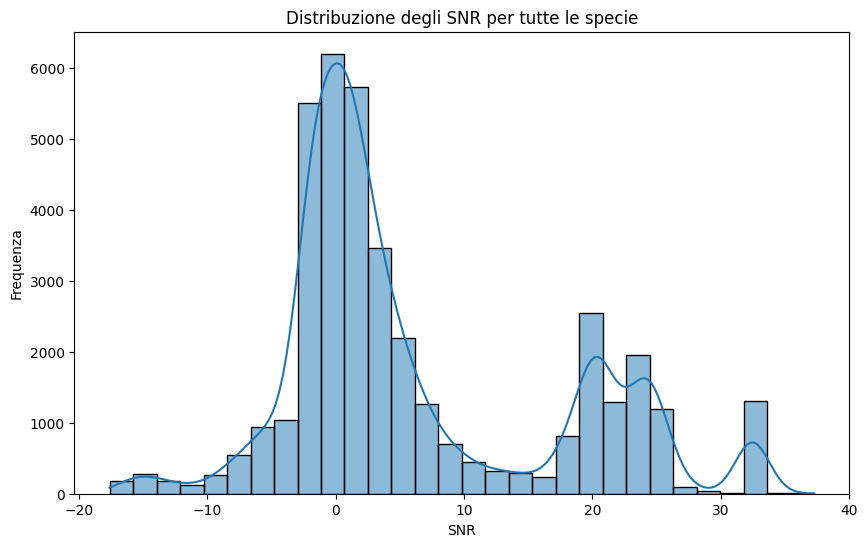

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Raccolta di tutti gli SNR in una lista unica
all_snr_values = []
for specie in info:
    all_snr_values.extend(info[specie].values())

# Creazione dell'istogramma
plt.figure(figsize=(10, 6))
sns.histplot(all_snr_values, bins=30, kde=True)

# Titoli e labels
plt.title("Distribuzione degli SNR per tutte le specie")
plt.xlabel("SNR")
plt.ylabel("Frequenza")

# Mostra il grafico
plt.show()


In [15]:
# Initialize the dictionary to store the results
top_800_per_specie = {}

# Iterate through each species in the 'info' dictionary
for species, files in info.items():
    # Filter files with SNR less than 20 dB
    snr_below_20 = {file: snr for file, snr in files.items() if snr < 20}
    
    # Sort the filtered files by SNR in descending order
    sorted_files = sorted(snr_below_20.items(), key=lambda item: item[1], reverse=True)
    
    # Select the first 800 files from the sorted list
    best_800 = [file for file, snr in sorted_files[:800]]
    
    # Add the species and the list of the best 800 files to the results dictionary
    top_800_per_specie[species] = best_800

# The 'top_800_per_specie' dictionary now contains species as keys
# and lists of the best 800 audio files with SNR less than 20 dB as values

In [22]:
target_path = f"{DATASET_PATH}/snr_removed"
train_path = f"{DATASET_PATH}/train"
os.makedirs(target_path, exist_ok=True)
for species in os.listdir(train_path):
    if species not in species_to_reduce:
        continue
    for audio in os.listdir(os.path.join(train_path, species)):
        os.makedirs(os.path.join(target_path, species), exist_ok=True)
        if audio not in top_800_per_specie[species]:
            os.rename(
                os.path.join(train_path, species, audio),
                os.path.join(target_path, species, audio)
            )


In [22]:
print_dataset_count_table()

,train,valid,test
Species,,,
Fringilla coelebs_Common Chaffinch,5402,600,2040
Turdus philomelos_Song Thrush,3886,431,58
Sylvia atricapilla_Eurasian Blackcap,2725,302,715
Regulus ignicapilla_Common Firecrest,2500,277,417
Erithacus rubecula_European Robin,1247,138,69
Troglodytes troglodytes_Eurasian Wren,1044,115,52
Regulus regulus_Goldcrest,495,55,106
Periparus ater_Coal Tit,286,31,116
Muscicapa striata_Spotted Flycatcher,231,25,64


### Undo SNR removal

In [4]:
import os
snr_folder_path = f"{DATASET_PATH}/snr_removed"
train_path = f"{DATASET_PATH}/train"
for species in os.listdir(snr_folder_path):
    for audio in os.listdir(os.path.join(snr_folder_path, species)):
        os.rename(
            os.path.join(snr_folder_path, species, audio),
            os.path.join(train_path, species, audio)
        )


### Undo WABAD from Train and Valid

In [ ]:
train_path = f"{DATASET_PATH}/train"
# valid_path = f"{DATASET_PATH}/valid"
wabad_segments = "E:/Giacomo/Tovanella/wabad_segments"

for species in os.listdir(train_path):
    for audio in os.listdir(os.path.join(train_path, species)):
        is_wabad = len(audio.split("_")[0]) != 8
        if is_wabad:
            os.rename(
                os.path.join(train_path, species, audio),
                os.path.join(wabad_segments, species, audio)
            )

### Undo Validation

In [18]:
train_path = f"{DATASET_PATH}/train"
valid_path = f"{DATASET_PATH}/valid"

for species in os.listdir(valid_path):
    for audio in os.listdir(os.path.join(valid_path, species)):
        os.rename(
            os.path.join(valid_path, species, audio),
            os.path.join(train_path, species, audio)
        )